In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import openslide
import cv2

import numpy as np
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import binary_opening, binary_closing, remove_small_objects, convex_hull_image
from torchvision.io import read_image
import torchvision.transforms.functional as F
import pyvips

WSIs are masked whereas TMAs are not. Use traditional image processing techniques to develop an algorithm for a tissue mask.

Data directory

In [2]:
DATA_DIR = 'Data/'
MODE = "DEV"

Load metadata

In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
train_df

image_id label  image_width  image_height  is_tma
0           4  HGSC        23785         20008   False
1          66  LGSC        48871         48195   False
2          91  HGSC         3388          3388    True
3         281  LGSC        42309         15545   False
4         286    EC        37204         30020   False
..        ...   ...          ...           ...     ...
533     65022  LGSC        53355         46675   False
534     65094    MC        55042         45080   False
535     65300  HGSC        75860         27503   False
536     65371  HGSC        42551         41800   False
537     65533  HGSC        45190         33980   False

[538 rows x 5 columns]

In [4]:
train_df[train_df.image_id==1666]

image_id label  image_width  image_height  is_tma
15      1666  HGSC        69900         16083   False

### Plot TMA images

No thumbnails of TMA images since they are already small and do not need to be resized in order to load.

In [5]:
tma_files = list(map(lambda image_id: f'{image_id}.png',train_df[train_df.is_tma==True].image_id.values))

In [6]:
def load_and_plot_thumbnails(thumbnail_files, folder='train_thumbnails'):
    plt.rcParams["savefig.bbox"] = 'tight'

    ncols = 5
    num_imgs = len(thumbnail_files)
    nrows = int(np.ceil(num_imgs / ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(12,nrows*3))
    for i, image_name in enumerate(thumbnail_files):
        image_path = os.path.join(DATA_DIR, folder, image_name)
        img = read_image(image_path).detach()
        #img = img.detach()
        img = F.to_pil_image(img)
        #print(f'Plotting at axis {i // ncols}, {i % ncols}')
        axs[i // ncols, i % ncols].imshow(np.asarray(img))
        axs[i // ncols, i % ncols].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[i // ncols, i % ncols].set_title(image_name.split('_')[0])

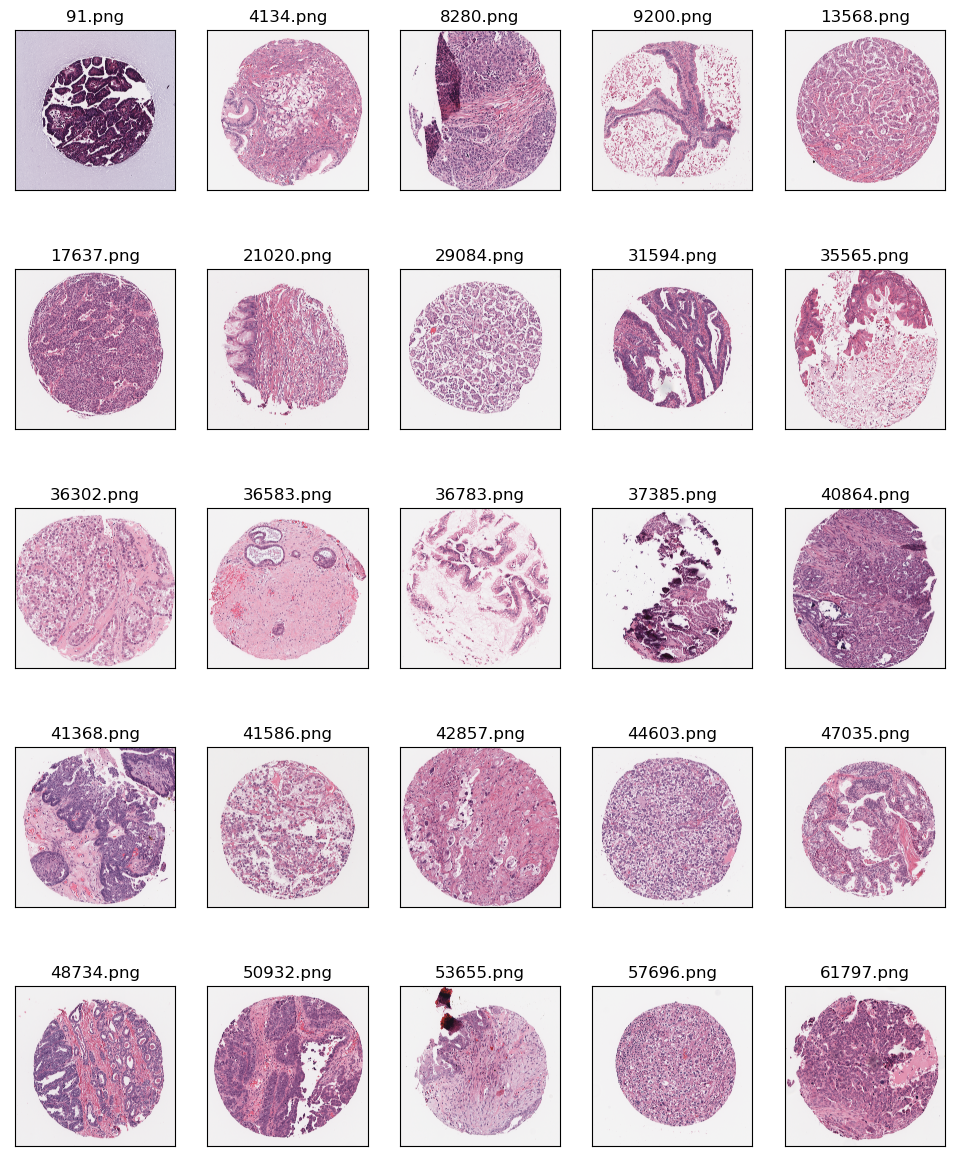

In [7]:
load_and_plot_thumbnails(tma_files, folder='train_images')

Background not already filtered for TMAs. 

All are roughly circular.

### Define mask for TMAs

Start with one example image.

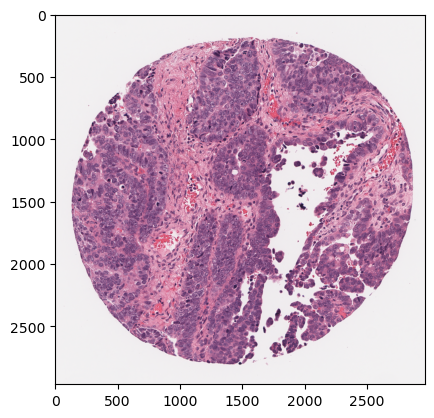

In [7]:
random_id = '50932'

image_path = os.path.join(DATA_DIR, 'train_images', f'{random_id}.png')
assert os.path.exists(image_path)

img = np.array(Image.open(image_path))[..., :3]
plt.imshow(img)
plt.show()

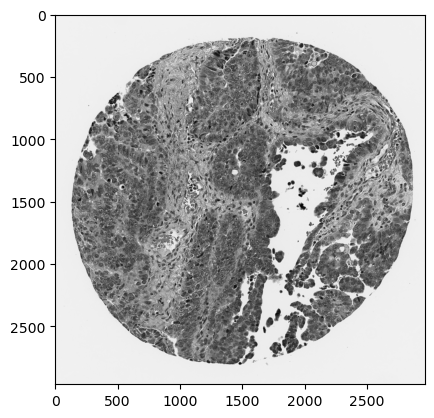

In [8]:
grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(grey_img, cmap='gray')

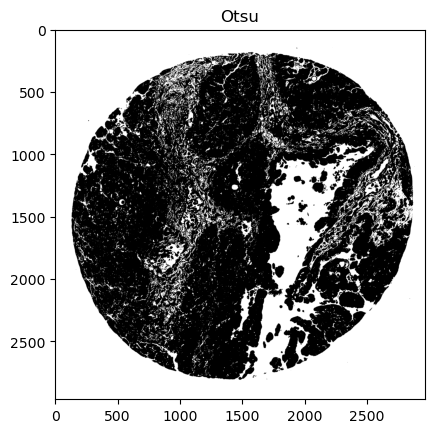

In [9]:
thresh = threshold_otsu(grey_img)

binary = grey_img > thresh

plt.imshow(binary, cmap=plt.cm.gray)
plt.title('Otsu')
plt.show()

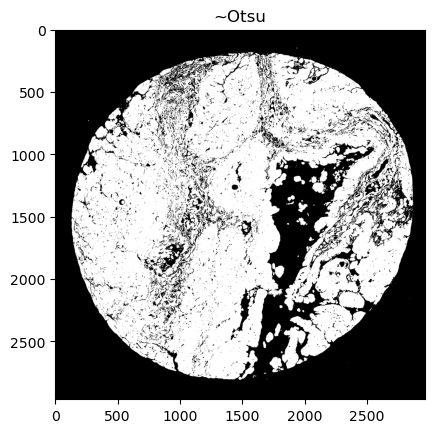

In [10]:
binary_mask = np.zeros(binary.shape, dtype=np.uint8)

binary_mask[~binary] = 1 # Optional

plt.imshow(binary_mask, cmap='gray')
plt.title('~Otsu')
plt.show()

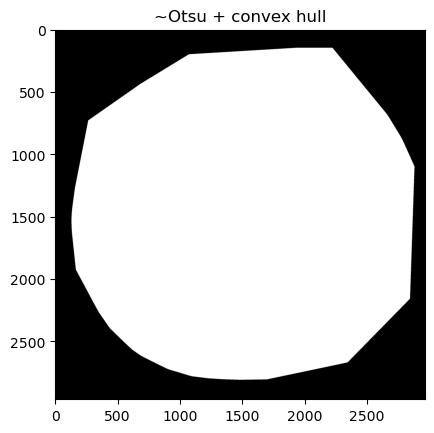

In [11]:
hull_mask = convex_hull_image(binary_mask)

plt.imshow(hull_mask, cmap='gray')
plt.title('~Otsu + convex hull')
plt.show()

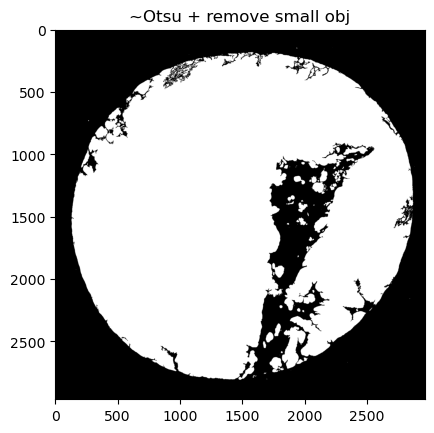

In [12]:
small_obj_mask = ~remove_small_objects(~binary_mask.astype(bool), min_size=64000, connectivity=1)

plt.imshow(small_obj_mask, cmap='gray')
plt.title('~Otsu + remove small obj')
plt.show()

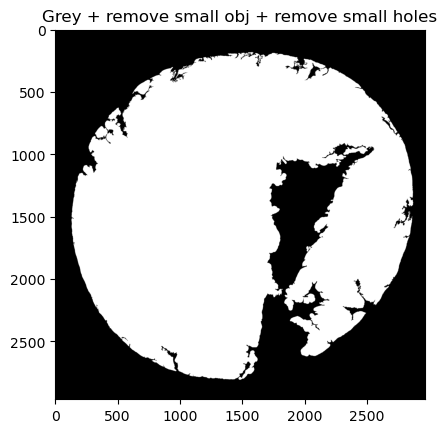

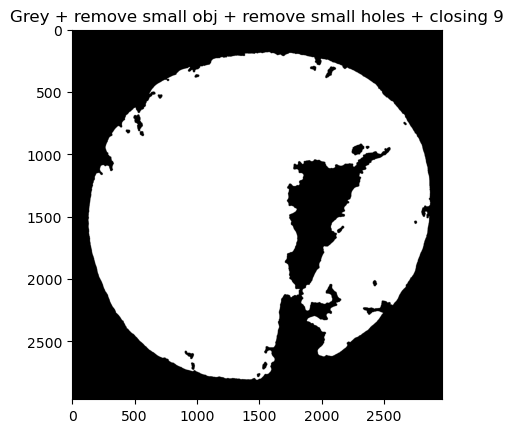

In [13]:
from skimage import color
from skimage import morphology

# Compute a mask
lum = color.rgb2gray(img)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < 0.7, 64000),
    64000)

plt.imshow(mask, cmap='gray')
plt.title('Grey + remove small obj + remove small holes')
plt.show()

mask = morphology.binary_closing(mask, morphology.disk(9))
plt.imshow(mask, cmap='gray')
plt.title('Grey + remove small obj + remove small holes + closing 9')
plt.show()

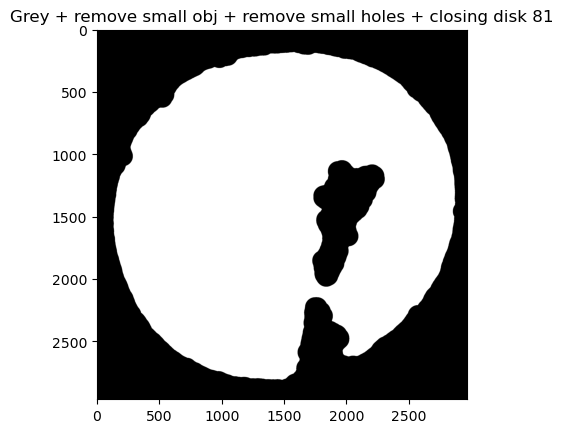

In [14]:
closed_mask = morphology.binary_closing(mask, morphology.disk(81)) # large disk radius takes longer
plt.imshow(closed_mask, cmap='gray')
plt.title('Grey + remove small obj + remove small holes + closing disk 81')
plt.show()

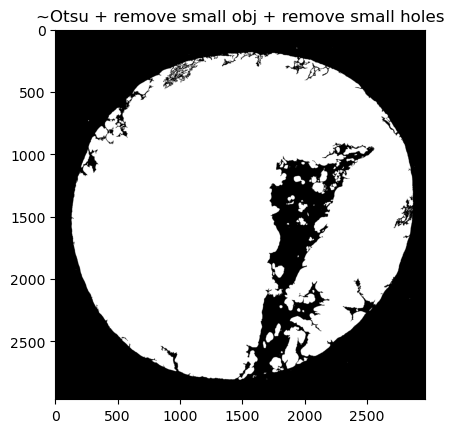

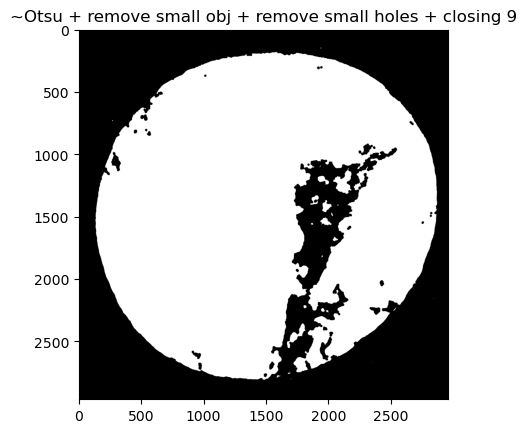

In [16]:
# Compute a mask
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        binary_mask, 64000),
    64000)

plt.imshow(mask, cmap='gray')
plt.title('~Otsu + remove small obj + remove small holes')
plt.show()

mask = morphology.binary_closing(mask, morphology.disk(9))
plt.imshow(mask, cmap='gray')
plt.title('~Otsu + remove small obj + remove small holes + closing 9')
plt.show()

In [17]:
binary_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Apply mask to image

In [18]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

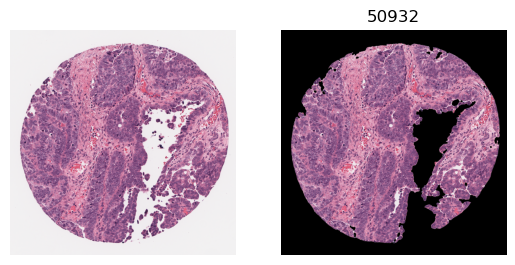

In [65]:
masked_img = img.copy()
masked_img[~mask] = 0

fig, axs = plt.subplots(1, 2)

axs[0].imshow(img)
axs[0].axis('off')
axs[1].imshow(masked_img)
axs[1].axis('off')
plt.title(random_id)
plt.show()

Problematic TMAs: 35565, 36783, 41386, 41586

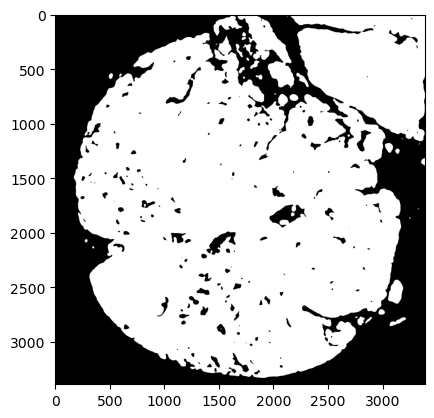

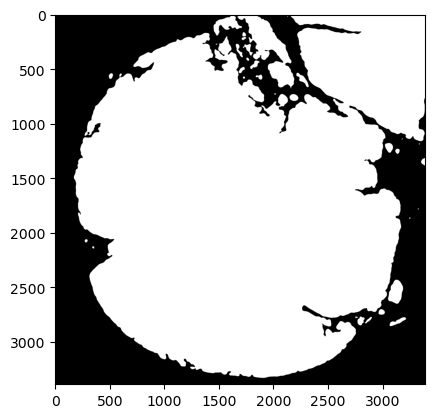

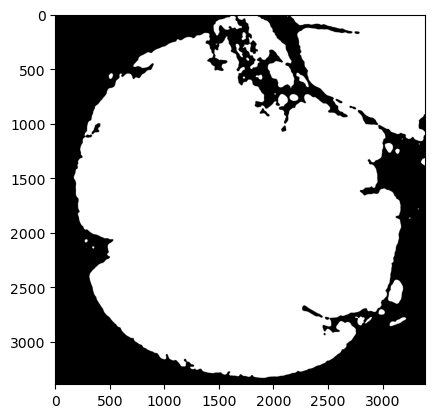

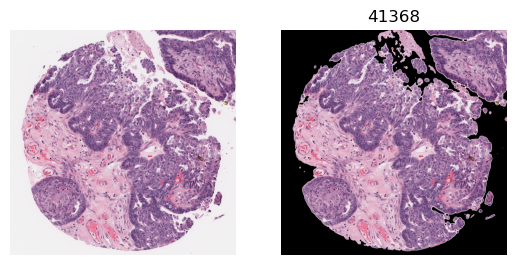

In [37]:
tma_id = '41368'

# Load image
image_path = os.path.join(DATA_DIR, 'train_images', f'{tma_id}.png')
assert os.path.exists(image_path)

img = np.array(Image.open(image_path))[..., :3]

# Compute a mask
grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
smooth_img = gaussian(grey_img, 9, preserve_range=False)

#thresh = threshold_otsu(smooth_img)
binary = smooth_img > 0.8


binary_mask = np.zeros(binary.shape, dtype=np.uint8)
binary_mask[~binary] = 1


plt.imshow(binary_mask, cmap='gray')
plt.show()


mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        binary_mask, 64000),
    64000)



plt.imshow(mask, cmap='gray')
plt.show()

mask = morphology.binary_closing(mask, morphology.disk(9))


plt.imshow(mask, cmap='gray')
plt.show()

# Apply mask to image
masked_img = img.copy()
masked_img[~mask] = 0

# Plot comparison
fig, axs = plt.subplots(1, 2)

axs[0].imshow(img)
axs[0].axis('off')
axs[1].imshow(masked_img)
axs[1].axis('off')
plt.title(tma_id)
plt.show()

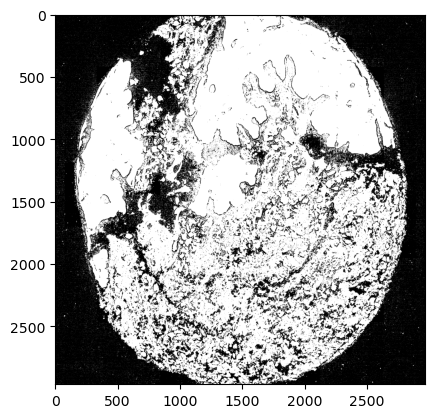

In [103]:
plt.imshow(grey_img<=237, cmap='gray')

Try contouring round circle

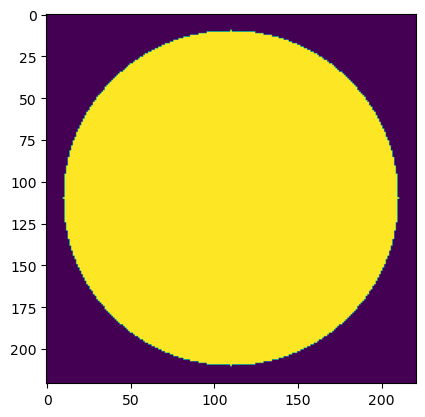

In [132]:
init_disk = np.pad(morphology.disk(2000), 100)
plt.imshow(init)

init_contour = find_contours(init_disk == label_i, 0.5)[0]

In [ ]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour

snake = active_contour(gaussian(img, 3, preserve_range=False),
                       init_contour, alpha=0.015, beta=10, gamma=0.001)
plt.imshow(snake)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img)
ax.plot(init[:, 1], init_contour[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

### Try smoothing image before Otsu

Apply gaussian to img to smooth, then apply Otsu thresholding

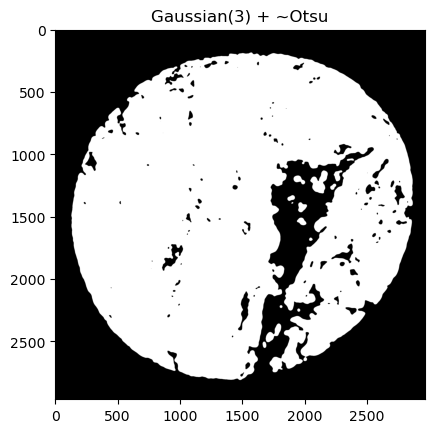

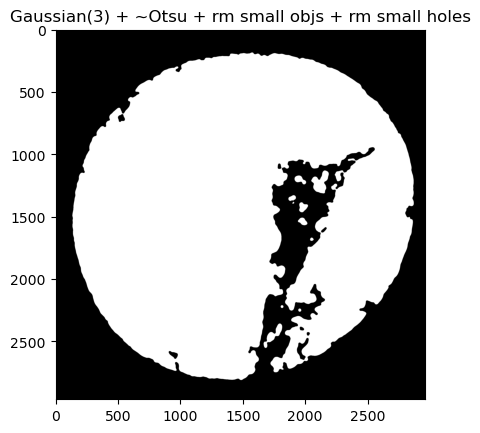

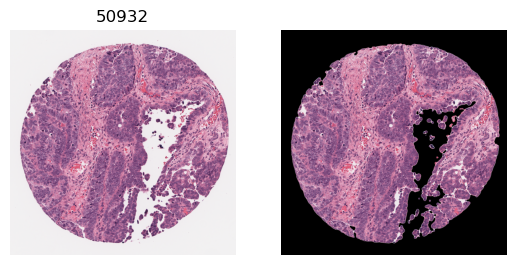

In [22]:
from skimage.filters import gaussian


# Compute a mask
grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
smooth_img = gaussian(grey_img, 9, preserve_range=False)

thresh = threshold_otsu(smooth_img)
binary = smooth_img > thresh

binary_mask = np.zeros(binary.shape, dtype=np.uint8)
binary_mask[~binary] = 1
plt.imshow(binary_mask, cmap='gray')
plt.title('Gaussian(3) + ~Otsu')
plt.show()

mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        binary_mask, 64000),
    64000)

mask = morphology.binary_closing(mask, morphology.disk(9))

# Apply mask to image
masked_img = img.copy()
masked_img[~mask] = 0

plt.imshow(mask, cmap='gray')
plt.title('Gaussian(3) + ~Otsu + rm small objs + rm small holes' )
plt.show()

# Plot comparison
fig, axs = plt.subplots(1, 2)

axs[0].imshow(img)
axs[0].axis('off')
axs[1].imshow(masked_img)
axs[1].axis('off')
axs[0].set_title(random_id)
plt.show()

#### Check generalised mask on all images

In [24]:
tma_ids = [file.split('.')[0] for file in tma_files]

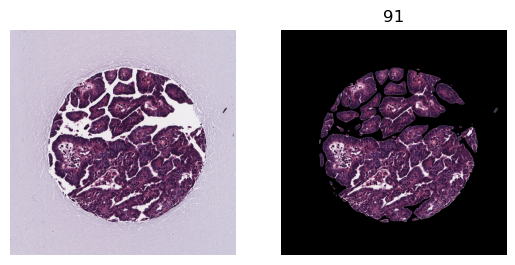

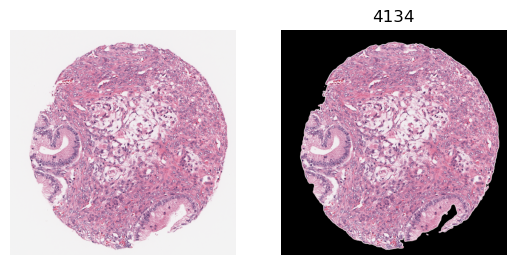

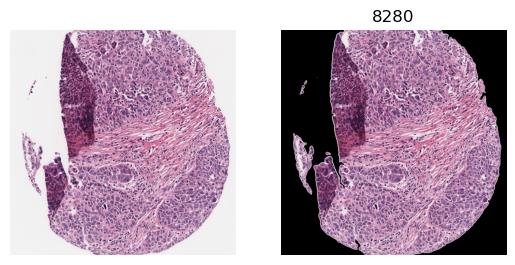

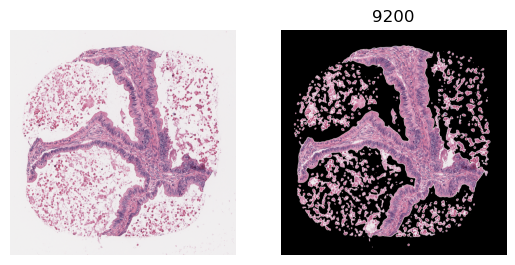

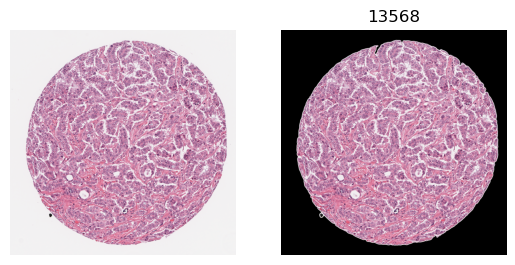

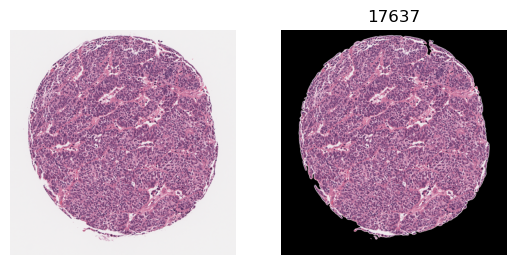

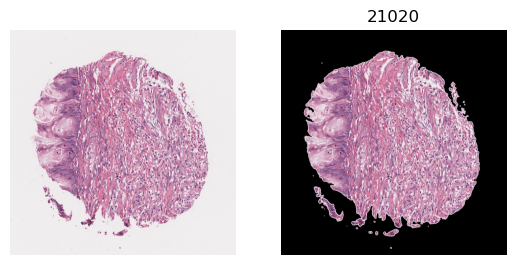

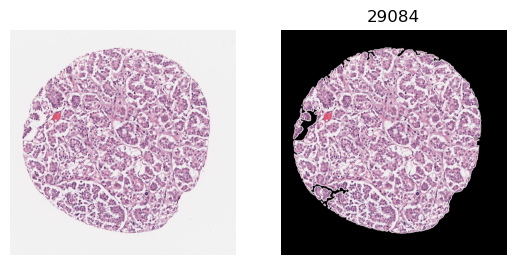

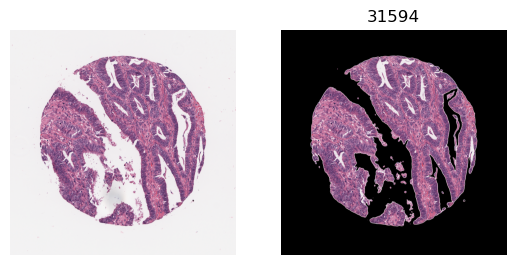

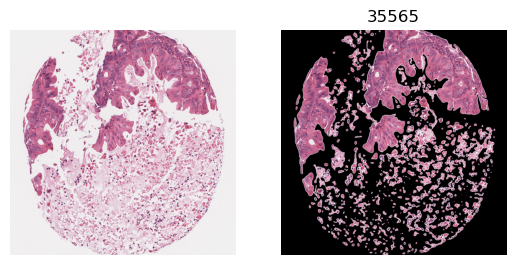

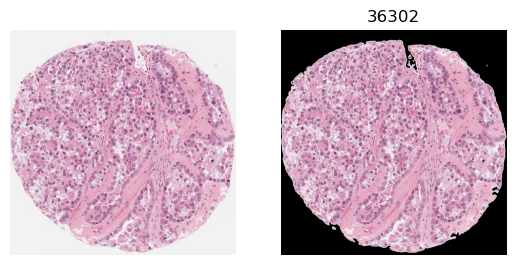

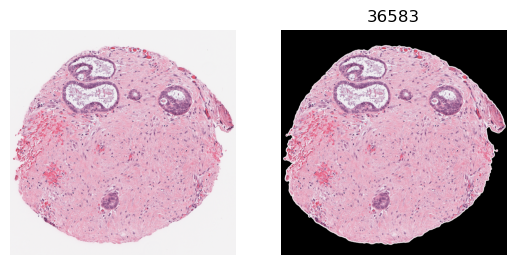

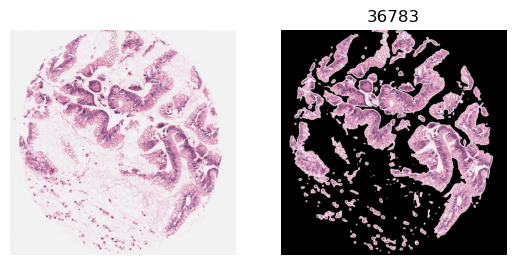

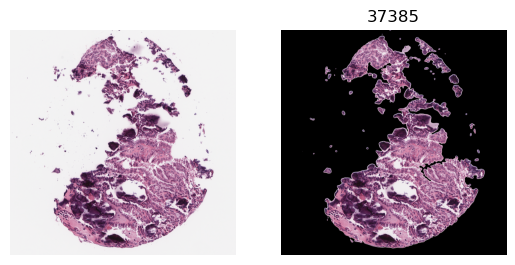

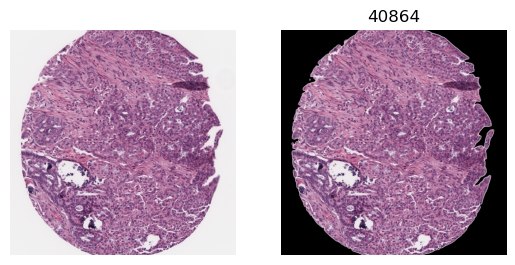

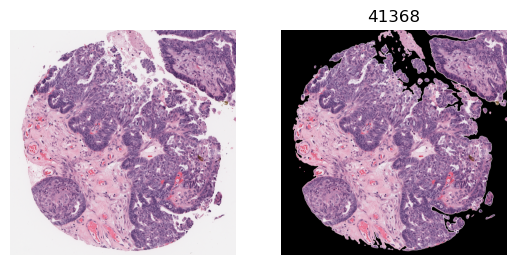

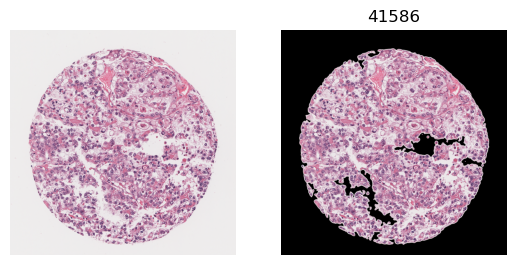

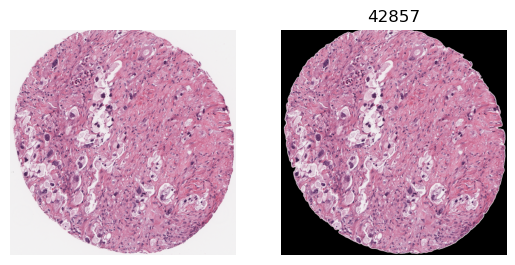

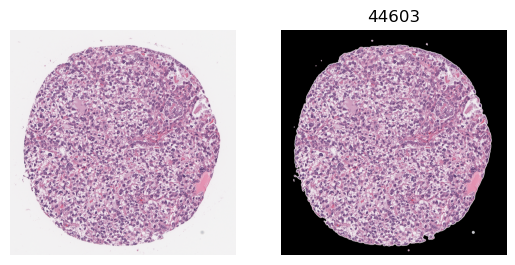

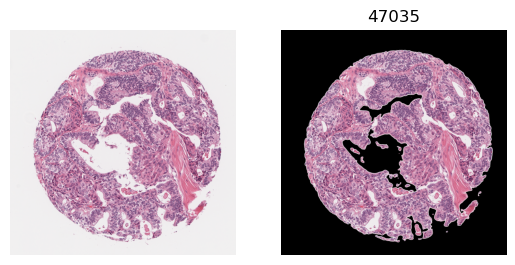

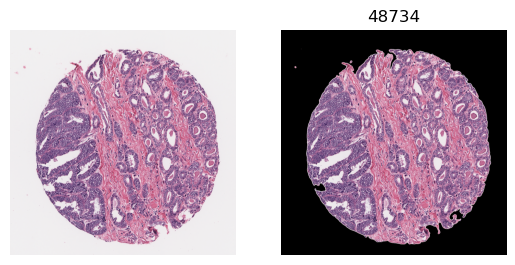

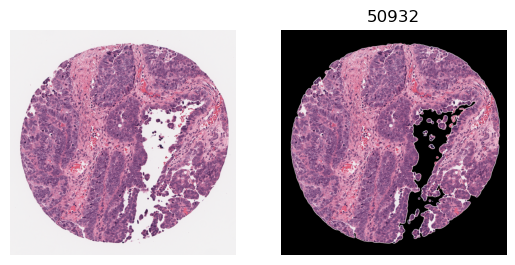

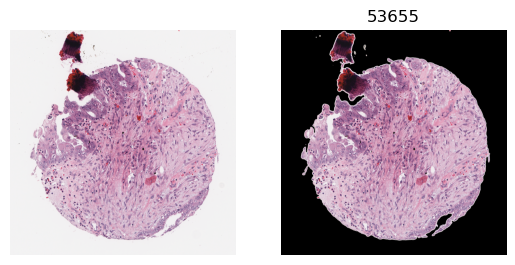

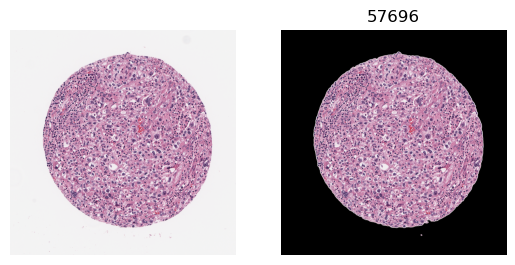

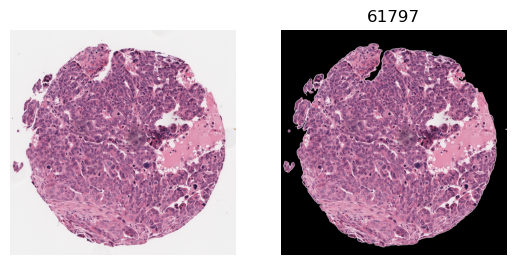

In [43]:
for tma_id in tma_ids:
    
    # Load image
    image_path = os.path.join(DATA_DIR, 'train_images', f'{tma_id}.png')
    assert os.path.exists(image_path)
    
    img = np.array(Image.open(image_path))[..., :3]
    
    # Compute a mask
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    smooth_img = gaussian(grey_img, 9, preserve_range=False)
    
    thresh = threshold_otsu(smooth_img)
    if thresh * 1.1 < 1:
        thresh = thresh * 1.1
    binary = smooth_img > thresh 
    
    
    binary_mask = np.zeros(binary.shape, dtype=np.uint8)
    binary_mask[~binary] = 1
    
    mask = morphology.remove_small_holes(
        morphology.remove_small_objects(
            binary_mask, 64000),
        64000)


    # Apply mask to image
    masked_img = img.copy()
    masked_img[~mask] = 0
    
    # Plot comparison
    fig, axs = plt.subplots(1, 2)
    
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(masked_img)
    axs[1].axis('off')
    plt.title(tma_id)
    plt.show()

### Final masking combination is:
- RGB to gray
- Guassian smooth radius 9
- Otsu thresholding
- Apply Otsu threshold * 1.1 to include fainter tissue
- Remove small objects at 64000
- Remove small holes at 64000

#### Save TMAs with black masks in tif format

In [64]:
for tma_id in tma_ids:
    
    # Load image
    image_path = os.path.join(DATA_DIR, 'train_images', f'{tma_id}.png')
    assert os.path.exists(image_path)
    
    img = np.array(Image.open(image_path))[..., :3]
    
    # Compute a mask
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    smooth_img = gaussian(grey_img, 9, preserve_range=False)
    
    thresh = threshold_otsu(smooth_img)
    if thresh * 1.1 < 1:
        thresh = thresh * 1.1
    binary = smooth_img > thresh 
    
    
    binary_mask = np.zeros(binary.shape, dtype=np.uint8)
    binary_mask[~binary] = 1
    
    mask = morphology.remove_small_holes(
        morphology.remove_small_objects(
            binary_mask, 64000),
        64000)


    # Apply mask to image
    masked_img = img.copy()
    masked_img[~mask] = 0
    
    
    try:
        masked_img_vips = pyvips.Image.new_from_array(masked_img)
        if MODE == 'KAGGLE': 
            masked_img_vips.tiffsave(f"{image_path[:-4]}.tif", tile=True, pyramid=True, bigtiff=True,
                                       tile_width=256, tile_height=256)
        elif MODE == 'DEV':
            masked_img_vips.tiffsave(f"{image_path[:-4]}.tif", tile=True, pyramid=True, bigtiff=False, 
                                       compression='jpeg', tile_width=256, tile_height=256)
        else:
            raise Exception(f'Mode {MODE} not found')
        print(f'Saved tif for image {tma_id}')
    except Exception:
        print(f'Couldn\'t save tif for TMA {tma_id}')

Saved tif for image 91
Saved tif for image 4134
Saved tif for image 8280
Saved tif for image 9200
Saved tif for image 13568
Saved tif for image 17637
Saved tif for image 21020
Saved tif for image 29084
Saved tif for image 31594
Saved tif for image 35565
Saved tif for image 36302
Saved tif for image 36583
Saved tif for image 36783
Saved tif for image 37385
Saved tif for image 40864
Saved tif for image 41368
Saved tif for image 41586
Saved tif for image 42857
Saved tif for image 44603
Saved tif for image 47035
Saved tif for image 48734
Saved tif for image 50932
Saved tif for image 53655
Saved tif for image 57696
Saved tif for image 61797
